## Yelp photo Classification with Transfer Learning. 

Note that the train, test and the valid dataset contains 5 classes: food, menu, outside, interior and drink. Here the train folder has 6000 images, the validation and test folder has 1000 images respectively.

In [1]:
# General Libs
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from pathlib import Path
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import glob

In [2]:
train_path = '/content/drive/MyDrive/Datasets/train_dir'
test_path = '/content/drive/MyDrive/Datasets/test_dir'
valid_path = '/content/drive/MyDrive/Datasets/valid_dir'

In [3]:
train_folder = Path(train_path)
test_folder = Path(test_path)
valid_folder=Path(valid_path)

In [4]:
train_folder = Path('/content/drive/MyDrive/Datasets/train_dir')
test_folder = Path(f'/content/drive/MyDrive/Datasets/test_dir')
valid_folder = Path('/content/drive/MyDrive/Datasets/valid_dir')

In [5]:
# Choose the hyperparameters
train_size = 6000
valid_size = 1000
test_size = 1000
img_height = 224
img_width = 224
n_classes = 5
batch_size = 32
n_epochs = 15

### Transfer Learning with VGG19

In [6]:
# Instantiate Data generator for VGG19
datagen = ImageDataGenerator(rescale=1.0 / 255,
                                 preprocessing_function=preprocess_input)

# Create batches of data from each set (train, test, validation)
train_ds = datagen.flow_from_directory(directory=train_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size)

valid_ds = datagen.flow_from_directory(directory=valid_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size)

test_ds = datagen.flow_from_directory(directory=test_folder,
                                              target_size=(img_height,
                                                           img_width),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              shuffle=False)

Found 6000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


In [7]:
labels = {value: key for key, value in train_ds.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : drink
1 : food
2 : interior
3 : menu
4 : outside


Let us see what are the images in the train generator

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


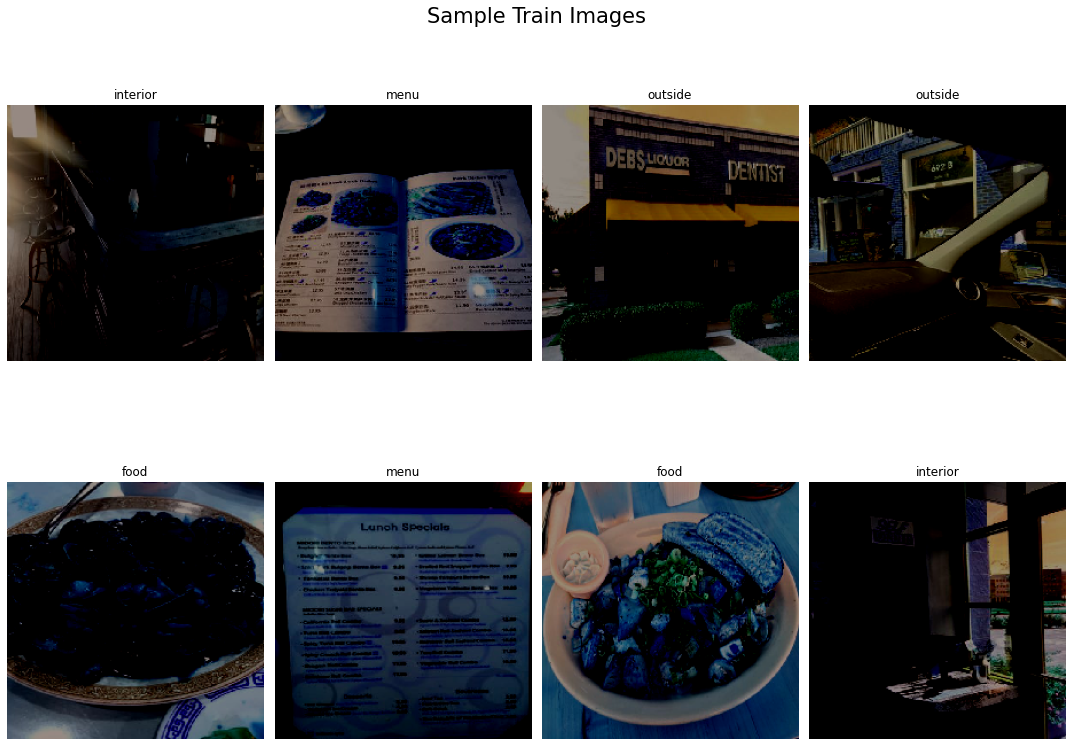

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(train_ds[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_ds[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Train Images", fontsize=21)
plt.show()

### Load the VGG19 Model

We are going to use the VGG19 as a transfer learning framework, we will use the pre-trained ImageNet weights with this model.

In [9]:
#Import the pretrained VGG19 model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_model.summary()

80150528/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [10]:
x = Flatten()(vgg_model.output)
x=Dropout(0.3)(x)
x = Dense(100, activation='relu')(x)
x=Dropout(0.2)(x)
# final softmax layer with 5 categories
predictions = Dense(5, activation='softmax')(x)

# creating the full model:
full_model = Model(inputs=vgg_model.input, outputs=predictions)

In [11]:
# Freezing Convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False

# Summarizing layers
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [12]:
opt = keras.optimizers.Adam(learning_rate=1e-5)
full_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

In [13]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

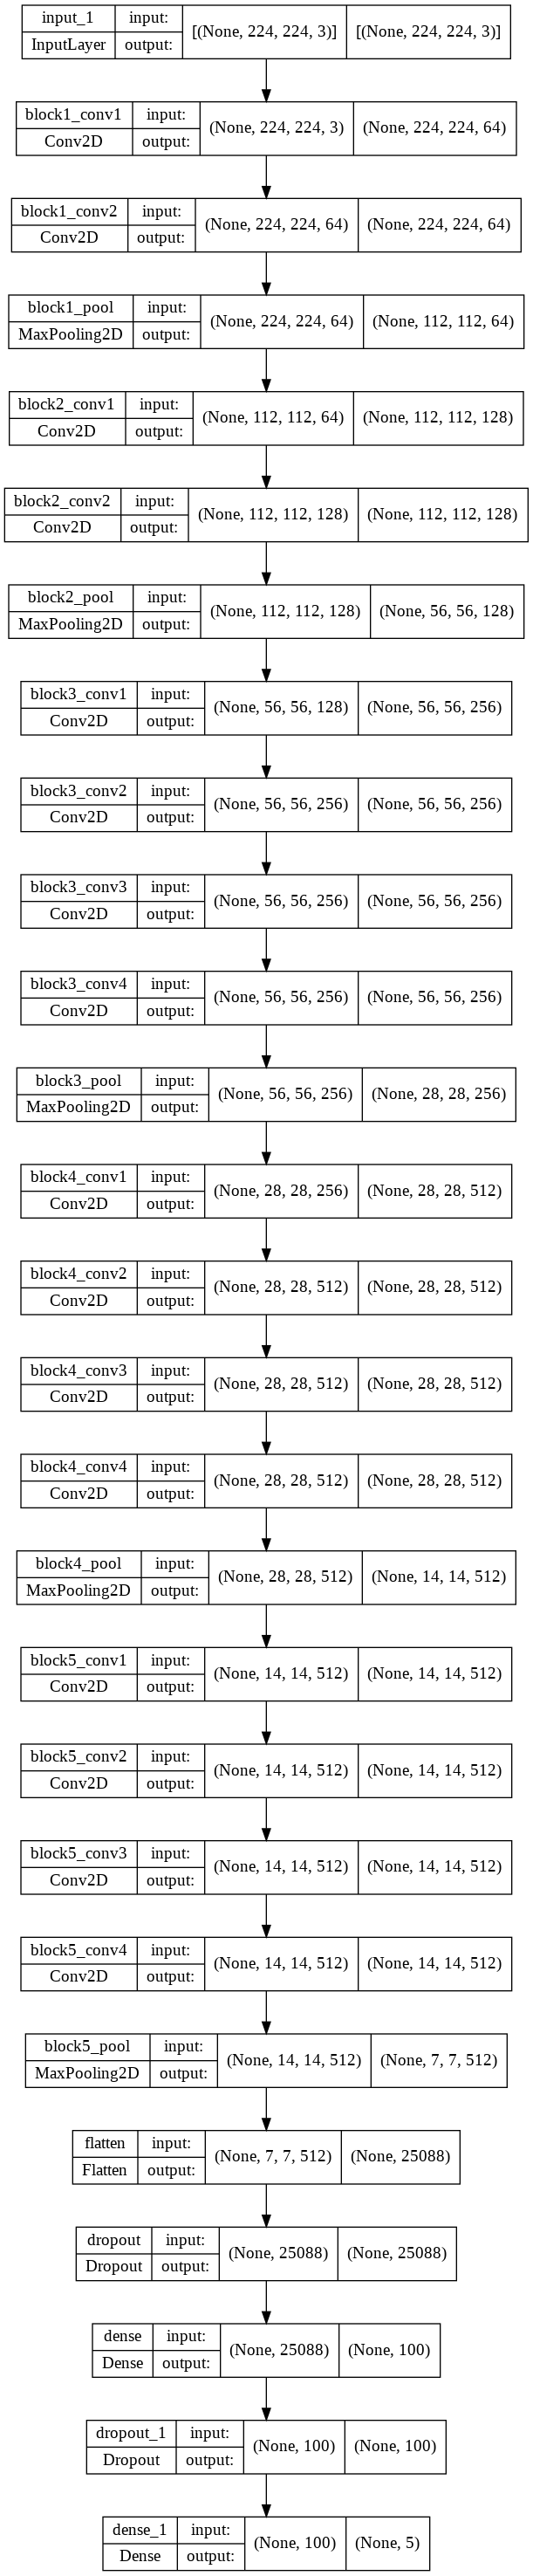

In [14]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(full_model, to_file=dot_img_file, show_shapes=True)

In [15]:
history = full_model.fit(train_ds,epochs=n_epochs,
                               validation_data=valid_ds,
                               steps_per_epoch=train_size / batch_size,
                               validation_steps=valid_size / batch_size, 
                               callbacks=[es])

Epoch 1/15
187/187 [==============================] - 1594s 8s/step - loss: 1.1738 - accuracy: 0.5153 - val_loss: 0.6885 - val_accuracy: 0.7580
Epoch 2/15
187/187 [==============================] - 89s 472ms/step - loss: 0.6902 - accuracy: 0.7310 - val_loss: 0.5424 - val_accuracy: 0.8100
Epoch 3/15
187/187 [==============================] - 89s 471ms/step - loss: 0.5869 - accuracy: 0.7718 - val_loss: 0.4956 - val_accuracy: 0.8140
Epoch 4/15
187/187 [==============================] - 88s 471ms/step - loss: 0.5178 - accuracy: 0.7997 - val_loss: 0.4715 - val_accuracy: 0.8320
Epoch 5/15
187/187 [==============================] - 88s 471ms/step - loss: 0.4762 - accuracy: 0.8250 - val_loss: 0.4386 - val_accuracy: 0.8370
Epoch 6/15
187/187 [==============================] - 88s 471ms/step - loss: 0.4375 - accuracy: 0.8377 - val_loss: 0.4380 - val_accuracy: 0.8320
Epoch 7/15
187/187 [==============================] - 88s 471ms/step - loss: 0.4177 - accuracy: 0.8432 - val_loss: 0.4114 - val_acc

In [16]:
from tensorflow.keras.models import load_model

full_model.save('/content/drive/MyDrive/Datasets/Models/VGG19.h5')

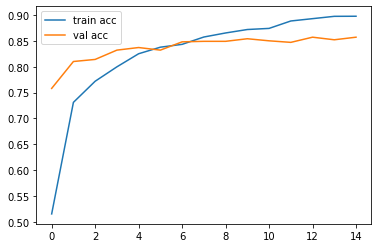

In [17]:
# accuracy
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.show()

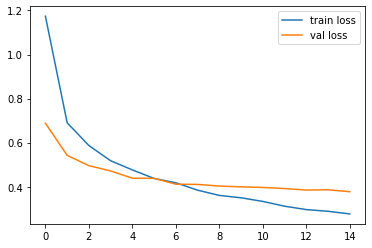

In [18]:
# loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

In [19]:
test_loss, test_accuracy = full_model.evaluate(test_ds)

32/32 [==============================] - 271s 9s/step - loss: 0.3616 - accuracy: 0.8660


In [20]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.36160409450531006
Test Accuracy: 0.8659999966621399


In [21]:
model = load_model('/content/drive/MyDrive/Datasets/Models/VGG19.h5')

In [22]:
preds = model.predict(test_ds, batch_size=batch_size)

y_pred=np.argmax(preds,axis=1)
y_true = test_ds.classes

In [23]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(test_ds.classes, y_pred)

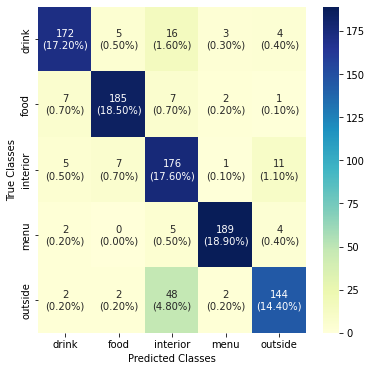

In [24]:
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(5, 5)

plt.figure(figsize = (6, 6))
sns.heatmap(cm, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


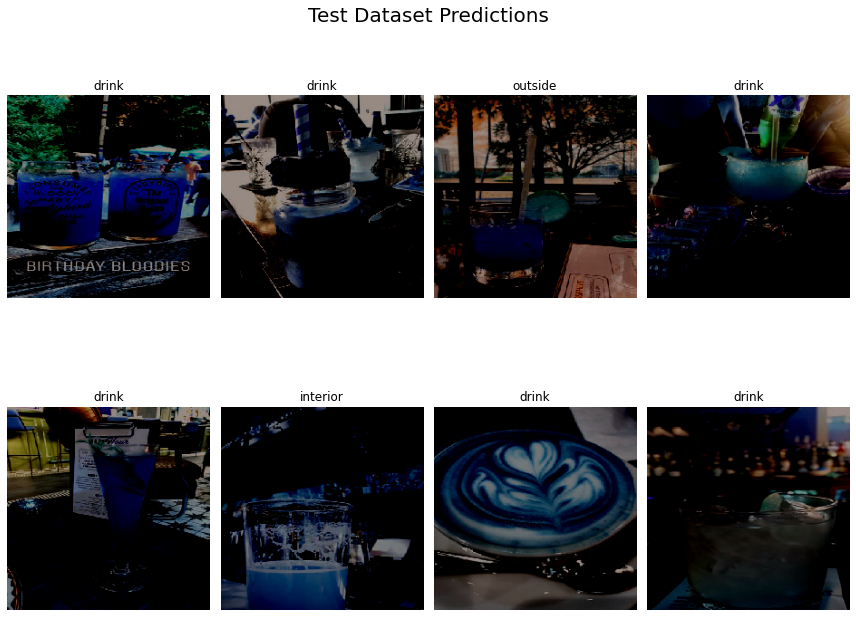

In [25]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        predicted_label = labels[np.argmax(preds[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_ds[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

#### Check the wrong prediction on the test dataset

In [26]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [27]:
test_images = test_ds.filenames
test_img = np.asarray(test_images)[errors]

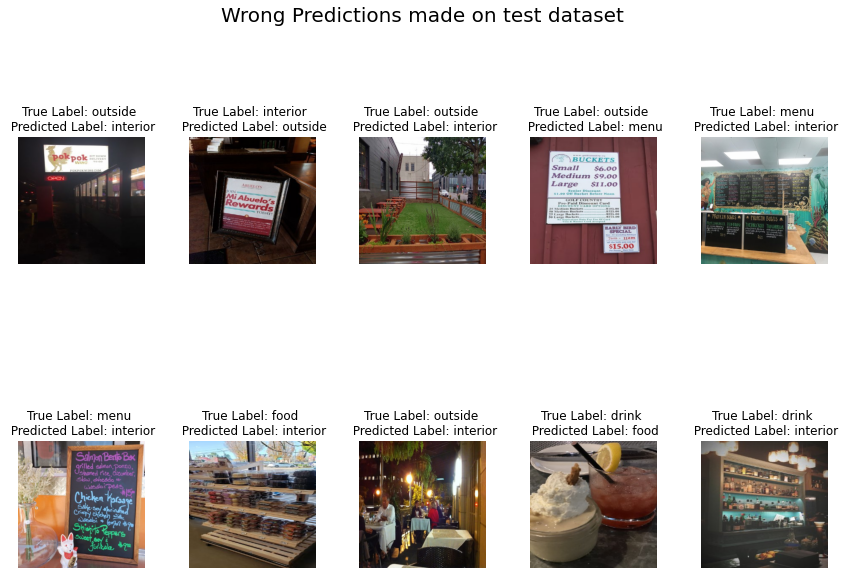

In [28]:
import cv2
import os

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_folder, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.resize(img, (256,256))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test dataset', fontsize=20)
plt.show()